# benchmark structural regression

In [254]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
import matplotlib.ticker as ticker
import sys
from math import *
from scipy.stats import binned_statistic

In [28]:
from utils_benchmark import * 
#test()

In [29]:
evaluation_dir = "/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/results/"
outdir = "../../../data/structural_regression/plots/02_benchmarkCPU/"

## families infos

In [30]:
#### Load datasets informations (Homfam + extHomfam)
summary_homfam_exthomfam = pd.read_csv("/home/luisasantus/Desktop/crg_cluster/data/structural_regression/stats/01_summary_homfam_exthomfam.csv")
summary_homfam_exthomfam = summary_homfam_exthomfam.rename(columns={"dataset": "benchmarking_dataset"})

## AF2 infos

In [31]:
# Load AF2 scores
af2 = pd.read_csv("/home/luisasantus/Desktop/crg_cluster/data/structural_regression/stats/02_summary_af2.csv")
af2_grouped = pd.read_csv("/home/luisasantus/Desktop/crg_cluster/data/structural_regression/stats/03_summary_af2_grouped.csv")

## running time

In [32]:
def extract_all_traces(dataset):
    # ---------- EXTRACT SEQUENCES ---------------
    #traces_extracted_sequences_homfam = get_computation_times(join(evaluation_dir, dataset), dataset, "seqs_extracted")
    # ---------- AF2 PREDICTIONS -------------------------
    # traces_af2_homfam = get_computation_times(join(evaluation_dir, dataset), dataset, "structures/colabfold")
    # ---------- ALIGNMENTS -------------------------
    traces_alignments_homfam = get_computation_times(join(evaluation_dir, dataset), dataset, "alignments", extralevel=True)
    # ---------- CONCATENATE AL OF THEM IN ONE ---------------
    traces = pd.concat([traces_alignments_homfam], ignore_index=True)
    return(traces)

traces = extract_all_traces("homfam")
traces.name.str.split(".", expand = True)[1].value_counts()

regressive     378
progressive    189
dynamic         56
Name: 1, dtype: int64

## msa evaluation 

In [33]:
dataset = "homfam"


eval_dir = join("/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/results/",dataset,"evaluation/CSV/")
scores_df = get_evaluation_all(eval_dir)
scores_df["benchmarking_dataset"] = dataset
scores_df["bucket_size"] = pd.to_numeric(scores_df.bucket_size)

# sep reference and full
scores_df["tag"] = scores_df.family.str.contains("_ref").map({True: 'ref', False: 'full'})
scores_df.family = scores_df.family.str.replace("_ref","")

scores_df.method.value_counts()

regressive     376
progressive    188
dynamic         56
Name: method, dtype: int64

In [58]:
scores_df_full = scores_df[scores_df.tag == "full"]
scores_df_ref = scores_df[scores_df.tag == "ref"]

## merge

In [111]:
def get_stats(scores_df, traces, summary_homfam_exthomfam):
    stats = pd.merge(scores_df, traces, on = ["name","benchmarking_dataset"])
    stats = pd.merge(stats, summary_homfam_exthomfam, on =["family","benchmarking_dataset"])
    stats_alignments = stats[stats.task == "alignments"]
    stats_alignments["approach"] = stats_alignments[["method", "bucket_size", "master_msa", "slave_msa", "dynamicX_val"]].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
    stats_alignments["fam_approach"] = stats_alignments["family"]+"_"+stats_alignments["approach"]
    stats_alignments.tc = pd.to_numeric(stats_alignments.tc)
    return(stats_alignments)

In [123]:
stats_alignments_full = get_stats(scores_df_full, traces, summary_homfam_exthomfam)
stats_alignments_ref = get_stats(scores_df_ref, traces, summary_homfam_exthomfam)
# Only keep the ones with ref 
stats_alignments_full = stats_alignments_full.loc[stats_alignments_full.fam_approach.isin(stats_alignments_ref.fam_approach)]
stats_alignments_full_sorted = stats_alignments_full.sort_values(by=["family", "approach"]).reset_index()
stats_alignments_ref_sorted = stats_alignments_ref.sort_values(by=["family", "approach"]).reset_index()
# ----------   Get diff TC --------- 
stats_alignments_full_sorted["diff_tc"] = stats_alignments_full_sorted.tc - stats_alignments_ref_sorted.tc

In [125]:
stats_alignments_full_sorted.head()

,level_0,index,name,sp,tc,column,family,method,bucket_size,master_msa,...,n_sequences,mean_length,min_length,max_length,file,size_group,perc_ref_total,approach,fam_approach,diff_tc
0,318,95,Acetyltransf.progressive.FAMSA.FAMSA-medoid,44.3,15.3,21.5,Acetyltransf,progressive,NaN,FAMSA,...,46285,82.989716,28,181,Acetyltransf,xlarge,0.012963,progressive_nan_FAMSA_nan_nan,Acetyltransf_progressive_nan_FAMSA_nan_nan,-15.4
1,317,309,Acetyltransf.regressive.1000.FAMSA.FAMSA-medoid,48.8,13.8,19.3,Acetyltransf,regressive,1000.0,FAMSA,...,46285,82.989716,28,181,Acetyltransf,xlarge,0.012963,regressive_1000.0_FAMSA_nan_nan,Acetyltransf_regressive_1000.0_FAMSA_nan_nan,-16.9
2,316,283,Acetyltransf.regressive.50.FAMSA.FAMSA-medoid,36.8,2.1,2.4,Acetyltransf,regressive,50.0,FAMSA,...,46285,82.989716,28,181,Acetyltransf,xlarge,0.012963,regressive_50.0_FAMSA_nan_nan,Acetyltransf_regressive_50.0_FAMSA_nan_nan,-28.6
3,210,120,Ald_Xan_dh_2.progressive.FAMSA.FAMSA-medoid,86.7,70.6,75.2,Ald_Xan_dh_2,progressive,NaN,FAMSA,...,2589,109.303978,29,804,Ald_Xan_dh_2,small,0.231750,progressive_nan_FAMSA_nan_nan,Ald_Xan_dh_2_progressive_nan_FAMSA_nan_nan,1.5
4,209,179,Ald_Xan_dh_2.regressive.1000.FAMSA.FAMSA-medoid,86.5,70.4,75.3,Ald_Xan_dh_2,regressive,1000.0,FAMSA,...,2589,109.303978,29,804,Ald_Xan_dh_2,small,0.231750,regressive_1000.0_FAMSA_nan_nan,Ald_Xan_dh_2_regressive_1000.0_FAMSA_nan_nan,1.3


# Dynamic params selection 

In [142]:
metrics = [["sp", "sum of pairs"], ["tc", "total column"], ["column", "column"]]
metrics = [["tc", "total column"]]

## DyanmicX

In [31]:
stats_alignments_dynamic = stats_alignments[stats_alignments.method =="dynamic"]

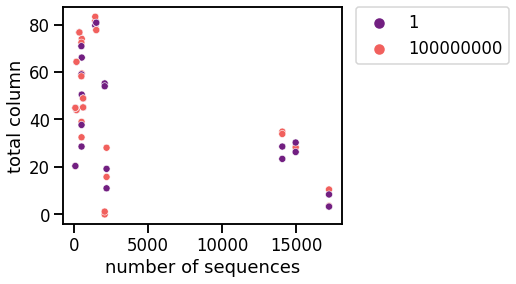

In [40]:
sns.set_context("talk")
#metrics = [["diff_sp", "sum of pairs"], ["diff_tc", "total column"], ["diff_column", "column"]]

for metric in metrics:
    f, ax = plt.subplots(figsize=(5, 4))
    sns.scatterplot(data=stats_alignments_dynamic, y=metric[0], x="n_sequences", hue="dynamicX_val",
                    palette = "magma", s = 50)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax.set(ylabel=  metric[1], xlabel='number of sequences')

## parent aligner 

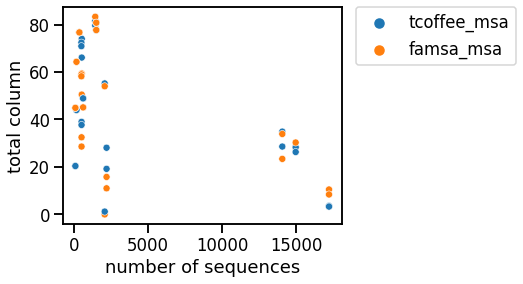

In [43]:
for metric in metrics:
    f, ax = plt.subplots(figsize=(5, 4))
    sns.scatterplot(data=stats_alignments_dynamic, y=metric[0], x="n_sequences", hue="master_msa",s = 50)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax.set(ylabel=  metric[1], xlabel='number of sequences')

# Performance

93681
1068
464


[Text(0.5, 0, 'number of sequences')]

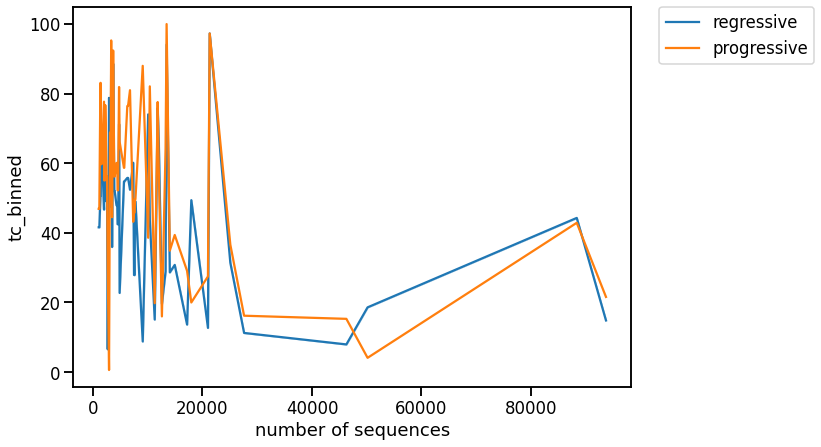

In [342]:
# try plotting with cumavg
sns.set_context("talk")
# Only keep 10k sequences or more 




bin_window = 200
n_bins = ceil((df.n_sequences.max()-df.n_sequences.min())/bin_window)
print(df.n_sequences.max())
print(df.n_sequences.min())
print(n_bins)
df = stats_alignments_full_sorted[stats_alignments_full_sorted.n_sequences>1000]
df = df.sort_values(by=["n_sequences"])
df["seq_bin"] = pd.cut(df.n_sequences, n_bins)
bin_means = pd.DataFrame(df.groupby(["seq_bin", "method"])["tc"].mean()).reset_index()
bin_means.columns = ['seq_bin', "method", 'tc_binned']
bin_means.head(1)
df = pd.merge(df, bin_means, on = ["seq_bin","method"])
df.head(2)


f, ax = plt.subplots(figsize=(10, 7))
x = df.n_sequences
y = (df.sort_values(by=["n_sequences"])["tc_binned"])
hue = df["method"]

g_results = sns.lineplot(x = x, y = y, hue = hue)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set(xlabel='number of sequences')

,level_0,index,name,sp,tc,column,family,method,bucket_size,master_msa,...,min_length,max_length,file,size_group,perc_ref_total,approach,fam_approach,diff_tc,seq_bin,tc_binned
0,246,238,gluts.regressive.50.FAMSA.FAMSA-medoid,89.400,72.100,77.400,gluts,regressive,50.000,FAMSA,...,41,224,gluts,large,0.139,regressive_50.0_FAMSA_nan_nan,gluts_regressive_50.0_FAMSA_nan_nan,-4.700,"(10015.418, 10934.82]",58.900
1,245,192,gluts.regressive.1000.FAMSA.FAMSA-medoid,92.900,76.000,81.200,gluts,regressive,1000.000,FAMSA,...,41,224,gluts,large,0.139,regressive_1000.0_FAMSA_nan_nan,gluts_regressive_1000.0_FAMSA_nan_nan,-0.800,"(10015.418, 10934.82]",58.900


# Regressive

In [158]:
stats_alignments_regressive = stats_alignments_full[stats_alignments_full.method =="regressive"]

#### Which is the bucket size effect? 

In [159]:
stats_alignments_regressive.bucket_size.value_counts()

50.0      94
1000.0    94
Name: bucket_size, dtype: int64

In [250]:

stats_alignments_regressive = stats_alignments_regressive.sort_values(by = "n_sequences")
stats_alignments_regressive["binned_seqs"] = pd.cut(stats_alignments_regressive.sort_values(by = "n_sequences")['n_sequences'], n_bins)

# ---------------------

## Plot average and std 

In [ ]:
nonreg_co_co_full<- nonreg_co_co[nonreg_co_co$tag == 'full',]
nonreg_co_co_ref<- nonreg_co_co[nonreg_co_co$tag == 'ref',]
nonreg_co_co_full_sorted <- nonreg_co_co_full[order(-nonreg_co_co_full$nseqs),]
nonreg_co_co_ref_sorted <- nonreg_co_co_ref[order(-nonreg_co_co_ref$nseqs),]
nonreg_co_co_diff <-  nonreg_co_co_full_sorted$tc_score - nonreg_co_co_ref_sorted$tc_score 
nonreg_co_co_cumsum <- cumsum(nonreg_co_co_diff)
nonreg_co_co_cumavg<-nonreg_co_co_cumsum/seq_along(nonreg_co_co_cumsum)
nonreg_co_co_cumsd<-sqrt(cum_var(nonreg_co_co_cumavg))
nonreg_co_co_cumsd[is.na(nonreg_co_co_cumsd)] <- 0

def cumsum(x): 
    return(list(x).cumsum())
def cum_var(x):
    ind_na = x.notna()
    nn = ind_na.cumsum()
    x[x.isna()] = 0
    cumsum(x^2) / (nn-1) - (cumsum(x))^2/(nn-1)/nn